# License Plate Recognition

With the advancement in technology especially in Image processing and Machine Learning, it is possible to make security cameras smarter by training them to process information from the Video feed. The video feed from these cameras can be used to perform face recognition, pattern analysis, emotion analysis and much more which would really get it close to something like the “**God’s Eye**” shown in the "Fast and Furious 7" movie.

 **Install & Import Dependencies**

In [1]:
!pip install easyocr
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive



**Read in Image , Grayscaling & Bluring**

Gray scaling is common in all image processing steps. This speeds up other following process since we no longer have to deal with the color details when processing an image.

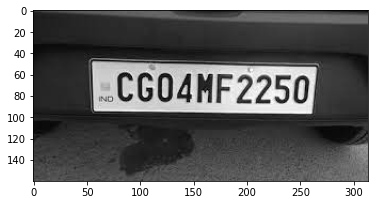

In [50]:
img = cv2.imread('/content/drive/MyDrive/Data Analysis/img/3.jpeg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  #Grayscaling
plt.imshow(cv2.cvtColor(gray,cv2.COLOR_BGR2RGB));  #For visualizing our resultant image in a graph

**Applying filter and finding edges for localization**

Every image will have useful and useless information, in this case for us only the license plate is the useful information the rest are pretty much useless for our program. This useless information is called **Noise**. Using a bilateral filter (**Bluring**) will remove the unwanted details from an image, this is one of the filtering techniques of Noise Reduction.


Edge detection is a technique of image processing used to identify points in a digital image with discontinuities, simply to say, sharp changes in the image brightness. These points where the image brightness varies sharply are called the edges (or boundaries) of the image. Among different techniques we'll use Canny edge detection method. But applying edge computation has some drawbacks like -- Size of output image will be shrunk, Loss of a lot of valuable information, especially from the edges of the input image. To overcome this, we usually use “padding” the input image before applying detection to avoid losing the valuable information in the input images.

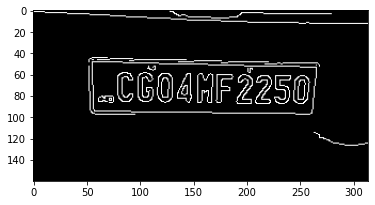

In [51]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB)); #For visualizing our resultant image in a graph

**Finding Contours and Applying Masking**

Image segmentation is a process by which we partition images into different regions. Whereas the **contours** are the continuous lines or curves that bound or cover the full boundary of an object in an image. And, here we will use image segmentation technique called contours to extract the parts of an image.

Once the counters have been detected we sort them from big to small and consider only the first 10 results ignoring the others. In our image the counter could be anything that has a closed surface but of all the obtained results the license plate number will also be there since it is also a closed surface.

In [52]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

To filter the license plate image among the obtained results, we will loop though all the results and check which has a rectangle shape contour with four sides and closed figure. Since a license plate would definitely be a rectangle four sided figure.

In [53]:
location=None
for contour in contours:
    approx=cv2.approxPolyDP(contour,10,True)
    if len(approx) == 4:
        location=approx
        break

In [54]:
location

array([[[ 55,  48]],

       [[ 57,  94]],

       [[262,  92]],

       [[265,  53]]], dtype=int32)

Masking is a nondestructive way to hide parts of an image or layer without erasing them, and showing only the desired objects in the image.

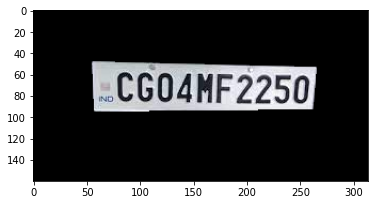

In [55]:
# Masking the part other than the number plate
mask=np.zeros(gray.shape,np.uint8)
new_image=cv2.drawContours(mask,[location],0,255,-1)
new_image=cv2.bitwise_and(img,img,mask=mask)

plt.imshow(cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB));

Segment the license plate out of the image by cropping it and saving it as a new image. We can then use this image to detect the character in it. 

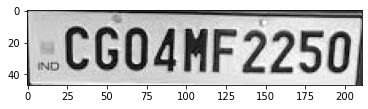

In [56]:
#cropping the image
(x,y)=np.where(mask==255)
(x1,y1)=(np.min(x),np.min(y))
(x2,y2)=(np.max(x),np.max(y))
cropped_image=gray[x1:x2+1,y1:y2+1]

plt.imshow(cv2.cvtColor(cropped_image,cv2.COLOR_BGR2RGB));

**Applying Easy OCR To Read Text**

In [57]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

[([[17, 3], [211, 3], [211, 47], [17, 47]], 'CGOAMF2250', 0.7381172921472376)]

**Rendering Result**

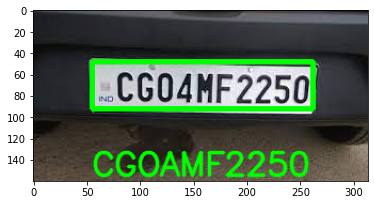

In [58]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)

plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB));